# Imports, data

In [1]:
import sys
from typing import Optional, Union, List

parentdir = '/Users/jerzypro/Documents/GitHub/FEDOT/'
bamtdir = '/Users/jerzypro/Documents/GitHub/BAMT'
sys.path.insert(0, parentdir)
sys.path.insert(0, bamtdir)

from math import ceil
from pgmpy.estimators import K2Score
from pgmpy.models import BayesianNetwork
from fedot.core.pipelines.convert import graph_structure_as_nx_graph
from fedot.core.optimisers.optimizer import GraphGenerationParams
from fedot.core.optimisers.graph import OptGraph, OptNode
from fedot.core.optimisers.objective.objective_eval import ObjectiveEvaluate
from fedot.core.optimisers.objective.objective import Objective
from fedot.core.optimisers.gp_comp.operators.selection import SelectionTypesEnum
from fedot.core.optimisers.gp_comp.gp_optimiser import EvoGraphOptimiser, GPGraphOptimiserParameters, \
    GeneticSchemeTypesEnum
from fedot.core.optimisers.adapters import DirectAdapter
from fedot.core.dag.verification_rules import has_no_cycle, has_no_self_cycled_nodes
from examples.divided_bn import DividedBN
from fedot.core.composer.gp_composer.gp_composer import PipelineComposerRequirements
import bamt.Preprocessors as pp
import bamt.Networks as Nets
from sklearn import preprocessing
import random
import pandas as pd
import numpy as np
from copy import deepcopy
from fedot.core.dag.graph import Graph
import time

/Users/jerzypro/Documents/GitHub/FEDOT/fedot/utilities/requirements_notificator.py:13: UserWarning: "opencv-python" is not installed, use "pip install .[extra]" to fulfil or ignore this warning
  warnings.warn(f'{msg} or ignore this warning')


In [ ]:
pigs = pd.read_csv(parentdir + 'examples/data/pigs.csv')
win95pts = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/win95pts.csv')
hailfinder = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/hailfinder.csv')
hepar2 = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/hepar2.csv')
arth150 = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/arth150.csv')
ecoli70 = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/ecoli70.csv')
magic_irri = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/magic-irri.csv')
magic_niab = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/magic-niab.csv')

pigs_true = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/pigs_true.csv')
win95pts_true = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/win95pts_true.csv')
hailfinder_true = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/hailfinder_true.csv')
hepar2_true = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/hepar2_true.csv')
arth150_true = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/arth150_true.csv')
ecoli70_true = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/ecoli70_true.csv')
magic_irri_true = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/magic-irri_true.csv')
magic_niab_true = pd.read_csv('https://raw.githubusercontent.com/jrzkaminski/BAMT-old/main/data/magic-niab_true.csv')

In [ ]:
def child_dict(net: list):
    res_dict = dict()
    for e0, e1 in net:
        if e1 in res_dict:
            res_dict[e1].append(e0)
        else:
            res_dict[e1] = [e0]
    return res_dict

def precision_recall(pred_net: list, true_net: list, decimal = 2):
    pred_dict = child_dict(pred_net)
    true_dict = child_dict(true_net)
    corr_undir = 0
    corr_dir = 0
    for e0, e1 in pred_net:
        flag = True
        if e1 in true_dict:
            if e0 in true_dict[e1]:
                corr_undir += 1
                corr_dir += 1
                flag = False
        if (e0 in true_dict) and flag:
            if e1 in true_dict[e0]:
                corr_undir += 1
    pred_len = len(pred_net)
    true_len = len(true_net)
    shd = pred_len + true_len - corr_undir - corr_dir
    return {'AP': round(corr_undir/pred_len, decimal), 'AR': round(corr_undir/true_len, decimal), 'AHP': round(corr_dir/pred_len, decimal), 'AHR': round(corr_dir/true_len, decimal), 'SHD': shd}


# Functions

In [ ]:
class CustomGraphModel(Graph):

    def __init__(self, nodes: Optional[Union[OptNode, List[OptNode]]] = None):
        super().__init__(nodes)
        self.unique_pipeline_id = 1


class CustomGraphNode(OptNode):
    def __str__(self):
        return self.content["name"]


# задаем метрику
def custom_metric(graph: CustomGraphModel, data: pd.DataFrame):
    graph_nx, labels = graph_structure_as_nx_graph(graph)
    struct = []
    for meta_edge in graph_nx.edges():
        l1 = str(labels[meta_edge[0]])
        l2 = str(labels[meta_edge[1]])
        struct.append([l1, l2])

    bn_model = BayesianNetwork(struct)
    bn_model.add_nodes_from(data.columns)

    global local_edges, root_nodes, child_nodes, initial_df

    # merge local edges into one list

    unpacked_hidden_edges = np.array([])

    for meta_edge in struct:
        meta_parent_node = str(meta_edge[0])
        local_root_nodes = root_nodes[int(str(meta_edge[0]))]
        local_child_nodes = child_nodes[int(str(meta_edge[1]))]
        for root_node in local_root_nodes:
            for child_node in local_child_nodes:
                np.append(unpacked_hidden_edges, [str(meta_parent_node), str(root_node)])
                np.append(unpacked_hidden_edges, [str(child_node), str(meta_parent_node)])

    bn_model.add_nodes_from(initial_df.columns)
    bn_model.add_edges_from(unpacked_hidden_edges)
    for key in local_edges:
        bn_model.add_edges_from(local_edges[key])

    full_data = pd.concat([data, initial_df], axis=1, join='inner')

    score = K2Score(full_data.sample(500)).score(bn_model)
    return [-score]


# задаем кроссовер (обмен ребрами)
def custom_crossover_exchange_edges(graph_first: OptGraph, graph_second: OptGraph, max_depth):
    def find_node(graph: OptGraph, node):
        return graph.nodes[dir_of_nodes[node.content['name']]]

    num_cros = 100
    try:
        for _ in range(num_cros):
            new_graph_first = deepcopy(graph_first)
            new_graph_second = deepcopy(graph_second)

            edges_1 = new_graph_first.operator.get_all_edges()
            edges_2 = new_graph_second.operator.get_all_edges()
            count = ceil(min(len(edges_1), len(edges_2)) / 2)
            choice_edges_1 = random.sample(edges_1, count)
            choice_edges_2 = random.sample(edges_2, count)

            for meta_edge in choice_edges_1:
                new_graph_first.operator.disconnect_nodes(meta_edge[0], meta_edge[1], False)
            for meta_edge in choice_edges_2:
                new_graph_second.operator.disconnect_nodes(meta_edge[0], meta_edge[1], False)

            old_edges1 = new_graph_first.operator.get_all_edges()
            old_edges2 = new_graph_second.operator.get_all_edges()

            new_edges_2 = [[find_node(new_graph_second, i[0]), find_node(new_graph_second, i[1])]
                           for i in choice_edges_1]
            new_edges_1 = [[find_node(new_graph_first, i[0]), find_node(new_graph_first, i[1])] for i in choice_edges_2]
            for meta_edge in new_edges_1:
                if meta_edge not in old_edges1:
                    new_graph_first.operator.connect_nodes(meta_edge[0], meta_edge[1])
            for meta_edge in new_edges_2:
                if meta_edge not in old_edges2:
                    new_graph_second.operator.connect_nodes(meta_edge[0], meta_edge[1])

            if old_edges1 != new_graph_first.operator.get_all_edges() or old_edges2 != new_graph_second.operator.get_all_edges():
                break

        if old_edges1 == new_graph_first.operator.get_all_edges() and new_edges_1 != [] and new_edges_1 != None:
            new_graph_first = deepcopy(graph_first)
        if old_edges2 == new_graph_second.operator.get_all_edges() and new_edges_2 != [] and new_edges_2 != None:
            new_graph_second = deepcopy(graph_second)
    except Exception as ex:
        print(ex)
    return new_graph_first, new_graph_second


# задаем три варианта мутации: добавление узла, удаление узла, разворот узла
def custom_mutation_add(graph: OptGraph, **kwargs):
    num_mut = 100
    try:
        for _ in range(num_mut):
            rid = random.choice(range(len(graph.nodes)))
            random_node = graph.nodes[rid]
            other_random_node = graph.nodes[random.choice(range(len(graph.nodes)))]
            nodes_not_cycling = (random_node.descriptive_id not in
                                 [n.descriptive_id for n in other_random_node.ordered_subnodes_hierarchy()] and
                                 other_random_node.descriptive_id not in
                                 [n.descriptive_id for n in random_node.ordered_subnodes_hierarchy()])
            if nodes_not_cycling:
                graph.operator.connect_nodes(random_node, other_random_node)
                break

    except Exception as ex:
        graph.log.warn(f'Incorrect connection: {ex}')
    return graph


def custom_mutation_delete(graph: OptGraph, **kwargs):
    num_mut = 100
    try:
        for _ in range(num_mut):
            rid = random.choice(range(len(graph.nodes)))
            random_node = graph.nodes[rid]
            other_random_node = graph.nodes[random.choice(range(len(graph.nodes)))]
            if random_node.nodes_from is not None and other_random_node in random_node.nodes_from:
                graph.operator.disconnect_nodes(other_random_node, random_node, False)
                break
    except Exception as ex:
        print(ex)
    return graph


def custom_mutation_reverse(graph: OptGraph, **kwargs):
    num_mut = 100
    try:
        for _ in range(num_mut):
            rid = random.choice(range(len(graph.nodes)))
            random_node = graph.nodes[rid]
            other_random_node = graph.nodes[random.choice(range(len(graph.nodes)))]
            if random_node.nodes_from is not None and other_random_node in random_node.nodes_from:
                graph.operator.reverse_edge(other_random_node, random_node)
                break
    except Exception as ex:
        print(ex)
    return graph


# задаем правила на запрет дублирующих узлов
def _has_no_duplicates(graph):
    _, labels = graph_structure_as_nx_graph(graph)
    if len(labels.values()) != len(set(labels.values())):
        raise ValueError('Custom graph has duplicates')
    return True

# Algorithm

In [ ]:
def get_edges_by_localstructures(data, datatype="discrete", max_local_structures=8):

    if 'Unnamed: 0' in data.columns:
        data = data.drop(['Unnamed: 0'], axis=1, inplace=True)

    data.dropna(inplace=True)
    data.reset_index(inplace=True, drop=True)

    global local_edges, root_nodes, child_nodes, initial_df

    initial_df = data

    # initialize divided_bn

    start_time = time.time()

    divided_bn = DividedBN(data=data, max_local_structures=max_local_structures)

    divided_bn.set_local_structures(data, datatype=datatype)

    local_edges = divided_bn.local_structures_edges

    divided_bn.set_hidden_nodes(data=data)

    hidden_df = pd.DataFrame.from_dict(divided_bn.hidden_nodes)

    hidden_df.columns = hidden_df.columns.astype(str)

    root_nodes = divided_bn.root_nodes
    child_nodes = divided_bn.child_nodes

    vertices = list(hidden_df.columns)

    encoder = preprocessing.LabelEncoder()
    discretizer = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
    p = pp.Preprocessor([('encoder', encoder), ('discretizer', discretizer)])
    discretized_data, _ = p.apply(hidden_df)

    # словарь: {имя_узла: уникальный_номер_узла}
    global dir_of_nodes
    dir_of_nodes = {hidden_df.columns[i]: i for i in range(len(hidden_df.columns))}

    # правила для байесовских сетей: нет петель, нет циклов, нет повторяющихся узлов
    rules = [has_no_self_cycled_nodes, has_no_cycle, _has_no_duplicates]

    # задаем для оптимизатора fitness-функцию
    objective = Objective(custom_metric)
    objective_eval = ObjectiveEvaluate(objective, data=discretized_data)
    # инициализация начальной сети (пустая)
    initial = [CustomGraphModel(nodes=[CustomGraphNode(nodes_from=None,
                                                    content={'name': vertex}) for vertex in vertices])]

    requirements = PipelineComposerRequirements(
        primary=vertices,
        secondary=vertices,
        max_arity=100,
        max_depth=100,
        pop_size=10,
        num_of_generations=50,
        crossover_prob=0.8,
        mutation_prob=0.9
    )

    optimiser_parameters = GPGraphOptimiserParameters(
        genetic_scheme_type=GeneticSchemeTypesEnum.steady_state,
        selection_types=[SelectionTypesEnum.tournament],
        mutation_types=[custom_mutation_add, custom_mutation_delete, custom_mutation_reverse],
        crossover_types=[custom_crossover_exchange_edges]
    )

    graph_generation_params = GraphGenerationParams(
        adapter=DirectAdapter(base_graph_class=CustomGraphModel, base_node_class=CustomGraphNode),
        rules_for_constraint=rules)

    optimiser = EvoGraphOptimiser(
        graph_generation_params=graph_generation_params,
        parameters=optimiser_parameters,
        requirements=requirements,
        initial_graph=initial,
        objective=objective)

    # запуск оптимизатора
    optimized_graph = optimiser.optimise(objective_eval)[0]

    print("--- %s seconds ---" % (time.time() - start_time))

    evolutionary_edges = optimized_graph.operator.get_all_edges()

    print('evolutionary_edges', evolutionary_edges)

    local_edges_merged = []
    external_edges = []

    for key in local_edges:
         local_edges_merged += local_edges[key]

    for meta_edge in evolutionary_edges:
        for root_node in root_nodes[int(str(meta_edge[0]))]:
            for child_node in child_nodes[int(str(meta_edge[1]))]:
                external_edges.append([root_node, child_node])

    all_edges = local_edges_merged + external_edges

    return all_edges


# Experiments

In [ ]:
pigs_evo = get_edges_by_localstructures(pigs, datatype="discrete", max_local_structures=20)

In [ ]:
precision_recall(pigs_evo, pigs_true.values.tolist())['SHD']

In [ ]:
win95pts_evo = get_edges_by_localstructures(win95pts, max_local_structures=4)


In [ ]:
precision_recall(win95pts_true.values.tolist(), win95pts_evo)['SHD']

In [ ]:
hailfinder_evo = get_edges_by_localstructures(hailfinder, max_local_structures=8)


In [ ]:
precision_recall(hailfinder_true.values.tolist(), hailfinder_evo)['SHD']

In [ ]:
hepar2_evo = get_edges_by_localstructures(hepar2, max_local_structures=4)


In [ ]:
precision_recall(hepar2_true.values.tolist(), hepar2_evo)['SHD']

In [ ]:
# # optimized_graph.show()

# external_edges = []

# local_edges_merged = []

# # for key in local_edges:
# #     local_edges_merged += local_edges[key]

# # for meta_edge in evolutionary_edges:
# #     for root_node in root_nodes[meta_edge[0]]:
# #         for child_node in child_nodes[meta_edge[1]]:
# #             external_edges.append([root_node, child_node])

# unpacked_hidden_edges = []

# for meta_edge in evolutionary_edges:
#     meta_parent_node = int(str(meta_edge[0]))
#     local_root_nodes = root_nodes[int(str(meta_edge[0]))]
#     local_child_nodes = child_nodes[int(str(meta_edge[1]))]
#     for root_node in local_root_nodes:
#         for child_node in local_child_nodes:
#             unpacked_hidden_edges.append([meta_parent_node, root_node])
#             unpacked_hidden_edges.append([child_node, meta_parent_node])

# print('Unpacked hidden edges:', unpacked_hidden_edges)

# all_edges = local_edges_merged + external_edges

# print("Evo edges:", evolutionary_edges)

In [ ]:
# bn_model = BayesianNetwork()
# bn_model.add_nodes_from(hidden_df.columns)

# unpacked_hidden_edges = np.array([])

# for meta_edge in evolutionary_edges:
#     meta_parent_node = str(meta_edge[0])
#     local_root_nodes = root_nodes[int(str(meta_edge[0]))]
#     local_child_nodes = child_nodes[int(str(meta_edge[1]))]
#     for root_node in local_root_nodes:
#         for child_node in local_child_nodes:
#             np.append(unpacked_hidden_edges, [str(meta_parent_node), str(root_node)])
#             np.append(unpacked_hidden_edges, [str(child_node), str(meta_parent_node)])

# bn_model.add_nodes_from(initial_df.columns)
# bn_model.add_edges_from(unpacked_hidden_edges)
# for key in local_edges:
#     bn_model.add_edges_from(local_edges[key])

# bn_model.nodes()

## Datavis

In [2]:
stat = pd.read_csv('/Users/jerzypro/Documents/GitHub/FEDOT/examples/pres.csv')
stat

,dataset,shd_sparsebn,time_sparsebn,shd_bidag,time_bidag,shd_brave,time_brave,shd_ga,time_ga,time_ga_hidden,shd_ga_hidden,time_ga_hidden_unpacked_est,shd_ga_hidden_unpacked_est
0,alarm,99,1345.317600,90,3.370051,39,1.195130,NaN,NaN,NaN,NaN,NaN,NaN
1,andes,692,2150.521800,669,171.480000,273,68.260170,NaN,NaN,NaN,NaN,NaN,NaN
2,barley,163,5242.298400,133,5.230051,106,1.943666,NaN,NaN,NaN,NaN,NaN,NaN
3,child,46,263.534816,46,2.285925,41,0.563999,NaN,NaN,NaN,NaN,NaN,NaN
4,diabetes,1311,0.000000,1081,871.261200,974,430.412490,NaN,NaN,NaN,NaN,NaN,NaN
5,hailfinder,130,1328.227200,130,350.453820,85,1.569062,123.0,305.0,7.8,60.0,59.70,92.0
6,hepar2,261,1905.402000,206,16.585530,120,2.591146,191.0,128.0,21.8,148.0,35.70,85.0
7,mildew,92,5332.536000,76,128.156040,54,0.591510,NaN,NaN,NaN,NaN,NaN,NaN
8,pigs*,1300,8630.359200,1171,1000.000000,979,465.420420,NaN,NaN,243.4,663.0,411.66,667.0
9,win95pts,216,993.667800,224,13.750460,144,3.549545,222.0,300.0,39.4,284.0,32.90,115.0


In [3]:
stat = stat.iloc[[5,6,9,11,12,13]]
stat

,dataset,shd_sparsebn,time_sparsebn,shd_bidag,time_bidag,shd_brave,time_brave,shd_ga,time_ga,time_ga_hidden,shd_ga_hidden,time_ga_hidden_unpacked_est,shd_ga_hidden_unpacked_est
5,hailfinder,130,1328.2272,130,350.453820,85,1.569062,123.0,305.0,7.8,60.0,59.7,92.0
6,hepar2,261,1905.4020,206,16.585530,120,2.591146,191.0,128.0,21.8,148.0,35.7,85.0
9,win95pts,216,993.6678,224,13.750460,144,3.549545,222.0,300.0,39.4,284.0,32.9,115.0
11,ecoli70,137,0.9400,140,5.547351,128,7.043300,132.0,288.0,28.4,89.0,NaN,NaN
12,magic-irri,205,1.2500,207,21.687420,144,5.412300,146.0,113.0,12.2,84.0,NaN,NaN
13,magic-niab,132,0.8980,128,6.791835,104,5.812700,105.0,70.0,19.9,94.0,NaN,NaN


<Figure size 640x480 with 0 Axes>

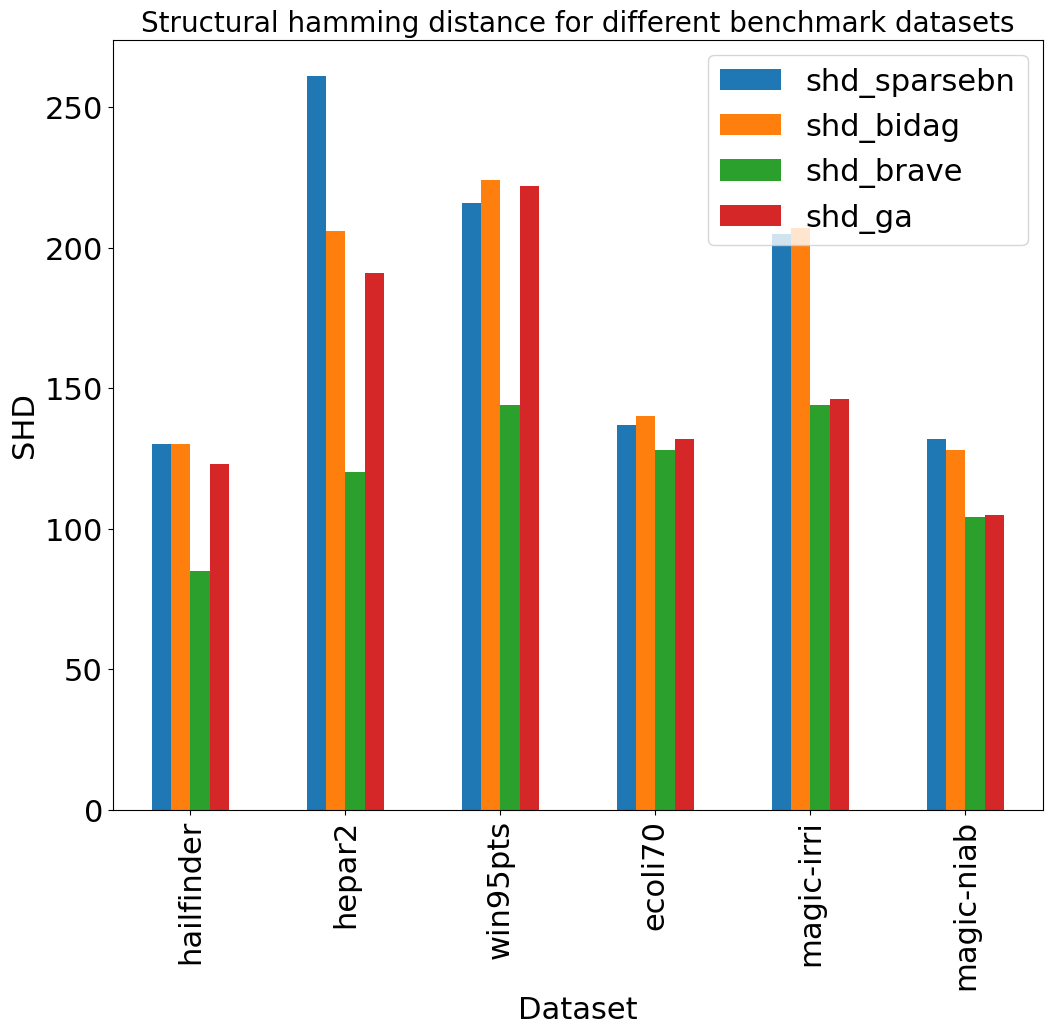

In [6]:
import matplotlib.pyplot as plt

plt.figure()
plt.rcParams.update({'font.size': 22})
stat.plot(x="dataset", y=["shd_sparsebn", "shd_bidag","shd_brave", "shd_ga"], kind="bar",figsize=(12,10))
plt.xlabel('Dataset', fontdict={'fontsize': 22})
plt.ylabel('SHD', fontdict={'fontsize': 22})
plt.title('Structural hamming distance for different benchmark datasets', fontdict={'fontsize': 20})
plt.show()

<Figure size 640x480 with 0 Axes>

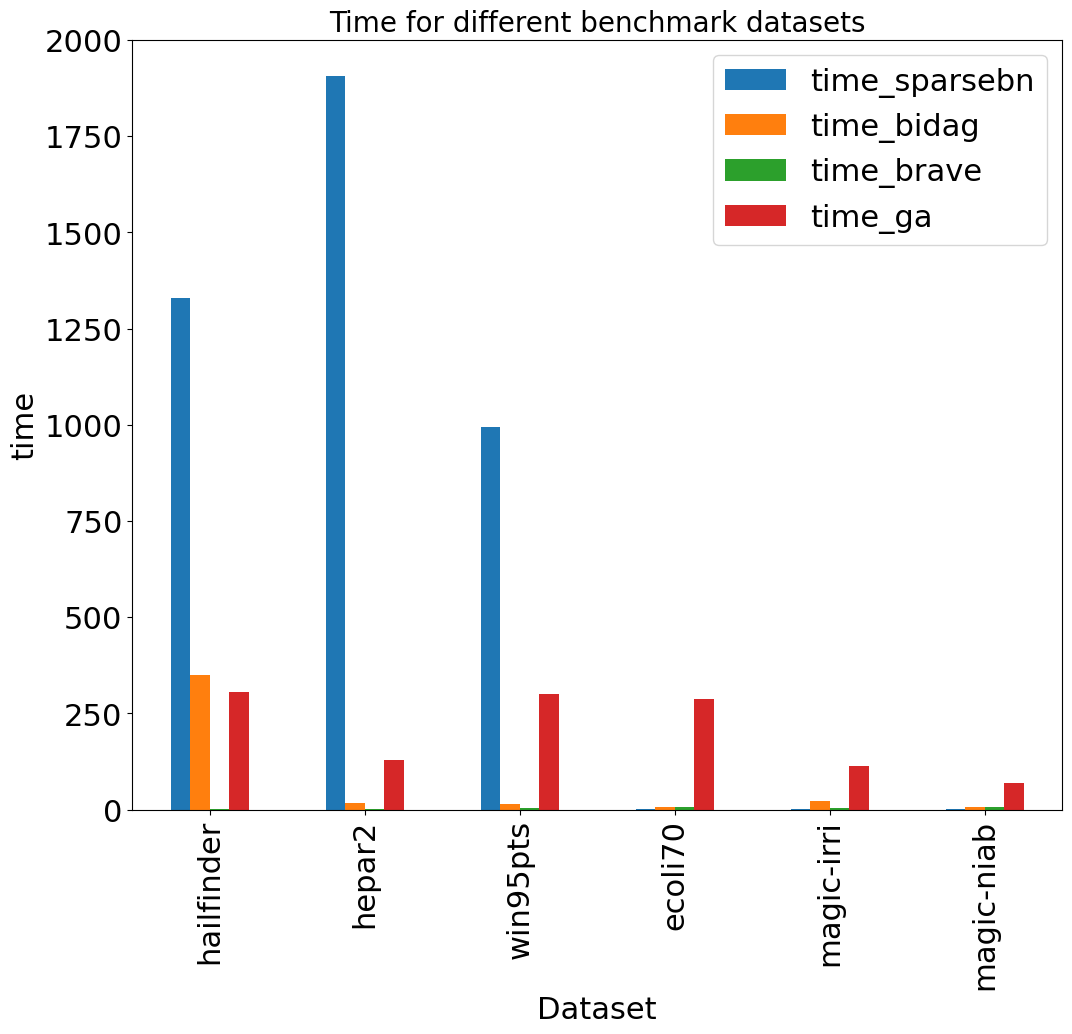

In [7]:
plt.figure()
plt.rcParams.update({'font.size': 22})
stat.plot(x="dataset", y=["time_sparsebn", "time_bidag","time_brave", "time_ga"], kind="bar",figsize=(12,10))
plt.xlabel('Dataset', fontdict={'fontsize': 22})
plt.ylabel('time', fontdict={'fontsize': 22})
plt.title('Time for different benchmark datasets', fontdict={'fontsize': 20})
plt.show()

<Figure size 640x480 with 0 Axes>

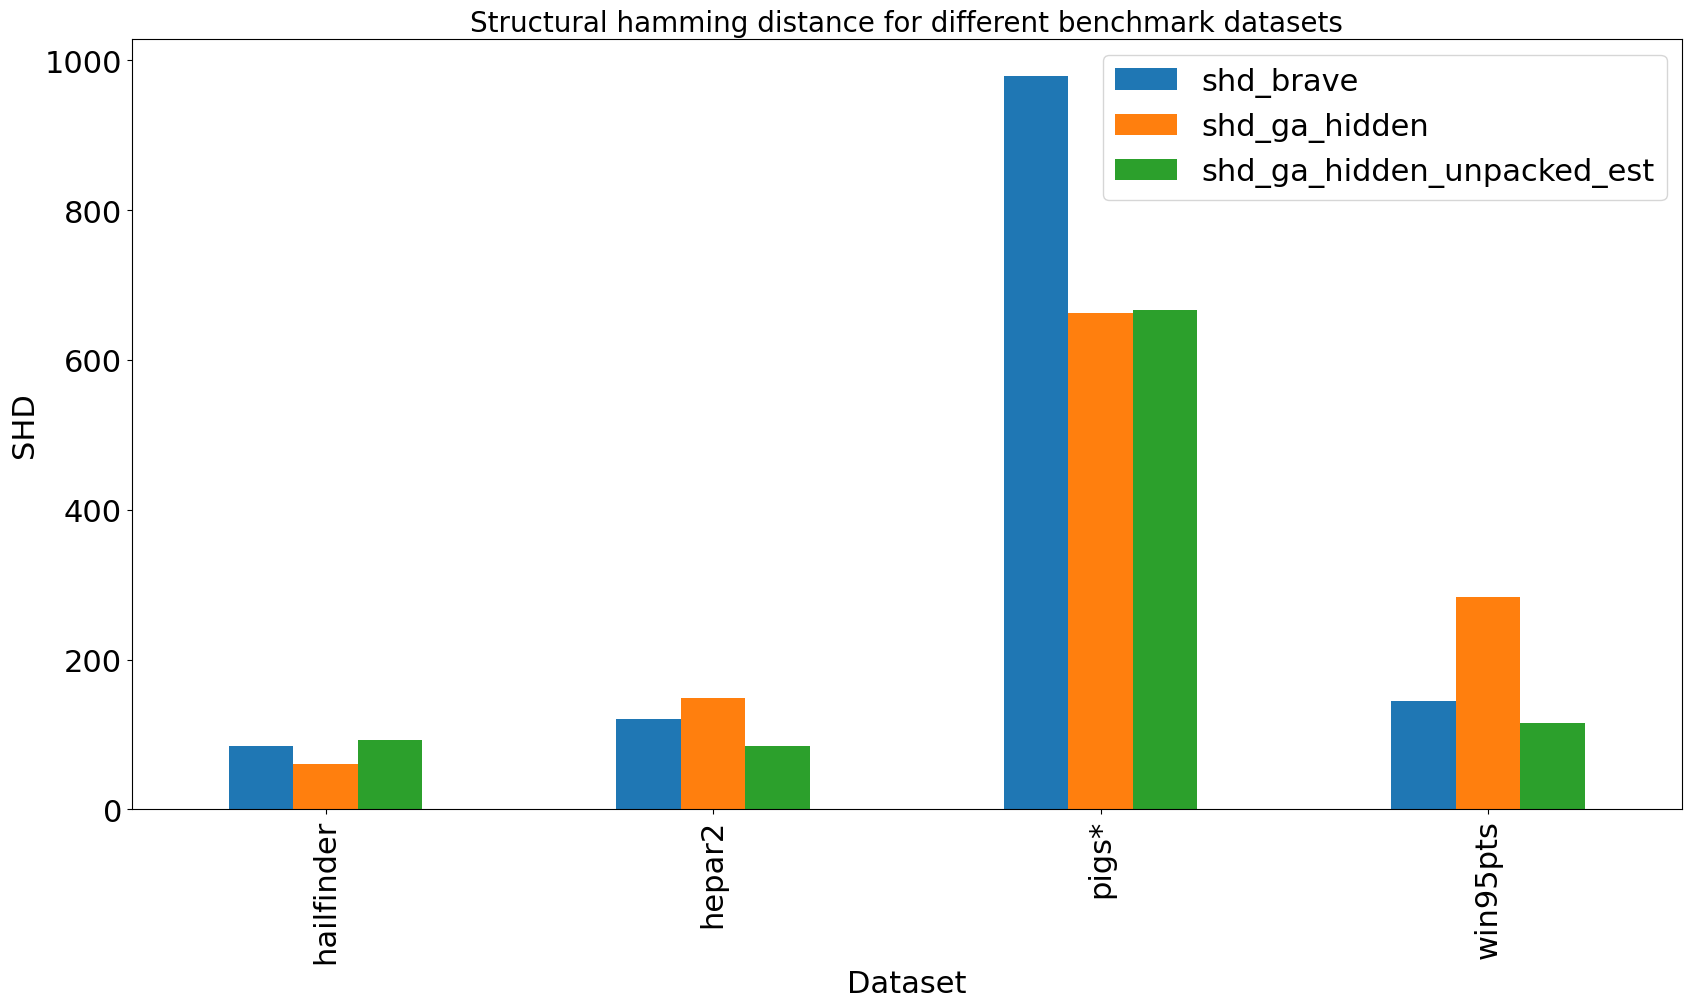

In [22]:
import matplotlib.pyplot as plt

plt.figure()
plt.rcParams.update({'font.size': 22})
stat.plot(x="dataset", y=["shd_brave", "shd_ga_hidden", "shd_ga_hidden_unpacked_est"], kind="bar",figsize=(20,10))
plt.xlabel('Dataset', fontdict={'fontsize': 22})
plt.ylabel('SHD', fontdict={'fontsize': 22})
plt.title('Structural hamming distance for different benchmark datasets', fontdict={'fontsize': 20})
plt.show()

<Figure size 640x480 with 0 Axes>

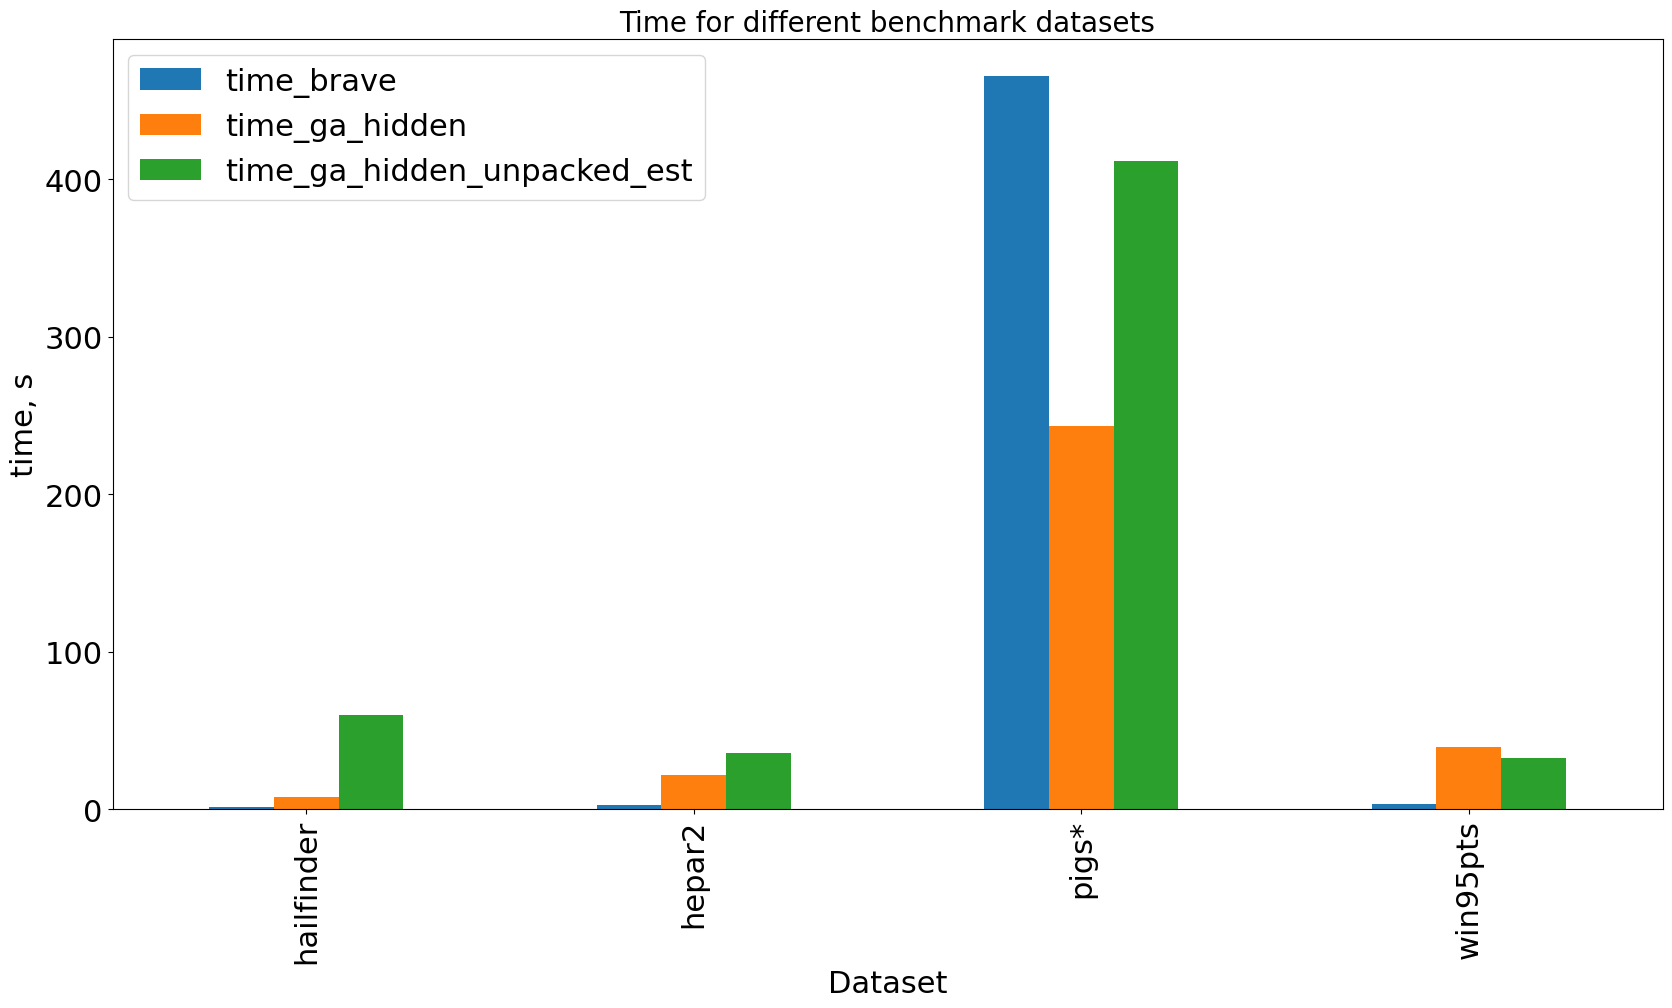

In [23]:
plt.figure()
plt.rcParams.update({'font.size': 22})
stat.plot(x="dataset", y=["time_brave", "time_ga_hidden", "time_ga_hidden_unpacked_est"], kind="bar",figsize=(20,10))
plt.xlabel('Dataset', fontdict={'fontsize': 22})
plt.ylabel('time, s', fontdict={'fontsize': 22})
plt.title('Time for different benchmark datasets', fontdict={'fontsize': 20})
plt.show()